## 1. 데이터 불러오기

- Selenium 패키지를 사용하여 2022년 4월 3일까지 게재된 '던파TV 채널'의 영상들에 있는 Title과 url을 수집한 뒤, url에 있는 video_id를 추출하였습니다.
- 추출된 video_id로 id에 맞는 영상의 게시시간, 영상의 조회수, 영상의 좋아요 수를 수집하였습니다.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
from tqdm import tqdm 
import time 
import re
from konlpy.tag import Mecab
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from PIL import Image
from collections import defaultdict
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [2]:
plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", rc={"axes.unicode_minus":False})

In [3]:
title_id_dataset = pd.read_csv("../data/analysis_data/title_id_date_view_like.csv", index_col=[0])
title_id_dataset.head()

,title,video_id,video_date,video_view,video_like
0,NEOPLE - 루키 4인팟이 전하는 입사 꿀팁,YOgOfpdHkRk,2022-03-30T04:24:50Z,2481,37
1,NEOPLE - 네오플과 함께한 16년,eJ76enP5JSQ,2022-03-30T04:24:45Z,2585,76
2,[던파] 우리는... 100의 민족입니까? (메이킹 필름),dlg9e5vZpSM,2022-03-28T02:37:57Z,1863,52
3,[던파] 던.직.이(?) 감스트가 소개하는 110레벨 만렙 확장 업데이트,FkD3jqoXquA,2022-03-17T04:04:13Z,18021,380
4,[던파] 우리는... 100의 민족입니까?,HbZFryV0JQ8,2022-03-17T03:03:55Z,984382,872


- video_id마다 달려있는 댓글 내용, 댓글 작성자, 댓글 작성시간, 댓글 좋아요 수를 수집하였습니다.

In [4]:
total_comments = pd.read_csv("../data/analysis_data/total_comment.csv", index_col=[0])
total_comments.head()

,comment,author,author_date,author_like,video_id
0,저는 이런 구직관련 마케팅도 너무 좋고 중요하다고 생각해요. 요즘 게임은 재미로만 ...,붐붐,2022-03-30T06:07:10Z,1,YOgOfpdHkRk
1,던파 진짜 많이개선되었죠,진 벤티,2022-04-03T04:35:57Z,0,YOgOfpdHkRk
2,개발자.. 개발자가 필요하다.. 존나 많은 개발자가..,ᄇᄇᄏ,2022-03-31T00:18:52Z,0,YOgOfpdHkRk
3,105 에픽 보조장비에 스킬공격력 증가를 추가로 8퍼센트 더 달아달라 ㅠㅠㅠ,버티는 마갤,2022-03-30T08:52:29Z,0,YOgOfpdHkRk
4,네오플 화이팅하새요,매드인형,2022-03-30T04:38:59Z,0,YOgOfpdHkRk


## 2. 데이터 전처리

### 2.1 중복 데이터 확인

In [5]:
print(f"영상제목 데이터셋 중복 결과 확인 전: {title_id_dataset.shape}")
print(f"영상제목 데이터셋 중복 결과 확인 후: {title_id_dataset.drop_duplicates().shape}")

영상제목 데이터셋 중복 결과 확인 전: (1213, 5)
영상제목 데이터셋 중복 결과 확인 후: (1213, 5)


In [6]:
print(f"댓글 데이터셋 중복 결과 확인 전: {total_comments.shape}")
print(f"댓글 데이터셋 중복 결과 확인 후: {total_comments.drop_duplicates().shape}")

댓글 데이터셋 중복 결과 확인 전: (71715, 5)
댓글 데이터셋 중복 결과 확인 후: (71712, 5)


In [7]:
# 중복되는 데이터
total_comments.iloc[np.arange(len(total_comments))[total_comments.reset_index(drop=True).duplicated()], :]

,comment,author,author_date,author_like,video_id
9,222🙂🤑w🤠22222@도독도독옹😀 비까지🙂 🙂🙂🙂😎🙂🤑😎🙂🙂😎😎🙂,re xsht,2020-08-28T07:18:12Z,0,NInrFWfVgQw
112,이거 라온님이 절반 불른거임? ㅎㄷㄷ,백민기,2016-07-21T13:12:35Z,0,Skgxe7qEZUE
94,순간화날뻔 <br>,박병종,2014-01-24T03:56:26Z,0,v_bpV-i0BCo


In [8]:
total_comments = total_comments.drop_duplicates()
print(f"댓글 데이터셋 중복 제거 후: {total_comments.shape}")

댓글 데이터셋 중복 제거 후: (71712, 5)


### 2.2 결측 데이터 확인

In [9]:
title_id_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1213 entries, 0 to 1212
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       1213 non-null   object
 1   video_id    1213 non-null   object
 2   video_date  1213 non-null   object
 3   video_view  1213 non-null   int64 
 4   video_like  1213 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 56.9+ KB


In [10]:
total_comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71712 entries, 0 to 59
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   comment      71712 non-null  object
 1   author       71705 non-null  object
 2   author_date  71712 non-null  object
 3   author_like  71712 non-null  int64 
 4   video_id     71712 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.3+ MB


### 2.3 댓글 데이터에 적용시킬 텍스트 전처리

- html 태그 제거
- 특수문자 제거
- 반복되는 공백 제거
- 앞 뒤 공백 제거
- Mecab으로 형태소 단위로 문장 분절
- 불용어 제거

In [11]:
def process(x, mecab, stopwords = False, split = False, min_len = None):
    
    # 같은 문장이 반복되는 경우
    if "<br>" in x:
        tmp = x.split("<br>")
        if tmp[0] == tmp[1]:
            x = tmp[0]
    
    # html 태그, 특수문자, 공백 제거
    x = re.sub("(<([^>]+)>)"," ", x)
    x = re.sub("[^a-zA-Zㄱ-ㅎ가-힣0-9]", " ", x)
    x = re.sub("[ ]+", " ", x)
    x = x.strip()
    
    # 필요한 경우 형태소 분석
    if split:
        x = mecab.morphs(x)
    
    # 필요한 경우 불용어 제거
    if stopwords:
        x = [i for i in x if i not in stopwords]
    
    if min_len:
        x = [i for i in x if len(i) >= min_len]
    
    return x

mecab = Mecab(dicpath=r"C:/mecab/mecab-ko-dic")
stopwords = ["은", "는", "이", "가", "는데", "지만", "으로", "세요", 
             "에서", "습니다", "한다", "인데", "면서", "부터", "아요",
            "ㅋㅋ", "ㅋㅋㅋ"]

### 3.4 던파TV 댓글 워드 임베딩 시각화

In [80]:
only_comments = total_comments["comment"].apply(lambda x : re.sub("[a-zA-Z0-9]","", x))
only_comments = only_comments.apply(lambda x: process(x, mecab, stopwords, split=True, min_len=2))
only_comments = only_comments.reset_index(drop=True)
only_comments = [i for i in only_comments if len(i) != 0]
only_comments[:3]

[['이런',
  '구직',
  '관련',
  '마케팅',
  '너무',
  '중요',
  '다고',
  '생각',
  '해요',
  '요즘',
  '게임',
  '재미',
  '아니',
  '사람',
  '많이',
  '져서',
  '부분',
  '이나',
  '스토리',
  '게임',
  '다양',
  '방면',
  '다양',
  '경험',
  '재미',
  '누리',
  '추세',
  '니까',
  '모쪼록',
  '더욱',
  '능력',
  '던파',
  '재미나',
  '만들',
  '도록',
  '이런',
  '활발',
  '던파',
  '소식',
  '응원'],
 ['던파', '진짜', '많이', '개선'],
 ['개발자', '개발자', '필요', '존나', '개발자']]

In [81]:
model = Word2Vec(sentences=only_comments, vector_size=100, window=5, min_count=1, workers=4, sg=1)
model.save("../word2vec.model")
word2vec_model = Word2Vec.load("../word2vec.model")
print(f" (단어의 개수 , 워드 임베딩 차원 수) : {word2vec_model.wv.vectors.shape}")
word2vec_model.wv.vectors

array([[-0.1427144 , -0.03938489,  0.3731141 , ..., -0.12849988,
         0.09709261,  0.5746215 ],
       [-0.27297565,  0.3144012 ,  0.19921504, ..., -0.24963453,
         0.12622435,  0.60986525],
       [-0.15068485, -0.05645111, -0.26192412, ..., -0.11017388,
        -0.29905427, -0.07180203],
       ...,
       [-0.01842342,  0.00933992,  0.02509432, ..., -0.04208321,
         0.0203252 ,  0.03548878],
       [-0.01790248,  0.03890396,  0.03162378, ..., -0.0662951 ,
         0.04679637,  0.05643147],
       [-0.01429265,  0.02513109,  0.04478643, ..., -0.08449306,
         0.02828773,  0.04390609]], dtype=float32)

In [108]:
keyword_list = ["루크", "로젠", "프레이", "시로코", "오즈마"]
word2vec_model.wv.most_similar("밸런스", topn=100)

[('패치', 0.8986139893531799),
 ('아빠', 0.8972020149230957),
 ('죽였', 0.8967894911766052),
 ('규모', 0.8505902886390686),
 ('구조', 0.8445562720298767),
 ('당연히', 0.8420690894126892),
 ('기준', 0.8371553421020508),
 ('놀음', 0.8340774178504944),
 ('조정', 0.8338874578475952),
 ('개판', 0.8295701146125793),
 ('적중', 0.8292899131774902),
 ('수치', 0.828061044216156),
 ('쓰레기', 0.8274418711662292),
 ('내놓', 0.8205669522285461),
 ('맞춰', 0.8203415274620056),
 ('일정', 0.819889485836029),
 ('고치', 0.8190508484840393),
 ('격차', 0.8183263540267944),
 ('맞추', 0.8177069425582886),
 ('방치', 0.8164471983909607),
 ('개선', 0.812507688999176),
 ('상시', 0.8116996884346008),
 ('개최', 0.8102497458457947),
 ('보정', 0.8088307976722717),
 ('인력', 0.808479368686676),
 ('데이터', 0.807478666305542),
 ('내역', 0.8073709607124329),
 ('병신', 0.8073379397392273),
 ('랍시고', 0.8070393800735474),
 ('사항', 0.8050667643547058),
 ('지속', 0.8031955361366272),
 ('패도', 0.8027116060256958),
 ('꼬라지', 0.8026133179664612),
 ('가치', 0.8008646368980408),
 ('유도', 0.8008

In [85]:
# 단어:단어임베딩 쌍의 dict 형성
vocab_dict = defaultdict()
for comment in only_comments:
    for word in comment:
        if word not in vocab_dict:
            vocab_dict[word] = 0
vocab_dict = dict(vocab_dict)            

for word in vocab_dict:
    vocab_dict[word] = word2vec_model.wv[word]

In [87]:
# 각 단어의 임베딩만 뽑아서 2D-array 형태로 만들어 줍니다.
tmp_vector= []
for vector in vocab_dict.values():
    tmp_vector.append(vector)
tmp_vector = np.array(tmp_vector)
tmp_vector.shape

(31331, 100)

In [88]:
# PCA로 기존 차원 수를 2개의 차원으로 축소시켜 줍니다.
pca = PCA(n_components=2)
pca_vectors = pca.fit_transform(tmp_vector)
pca_vectors.shape

(31331, 2)

In [91]:
pca_vectors = pca_vectors[:100]

IndexError: index 100 is out of bounds for axis 0 with size 100

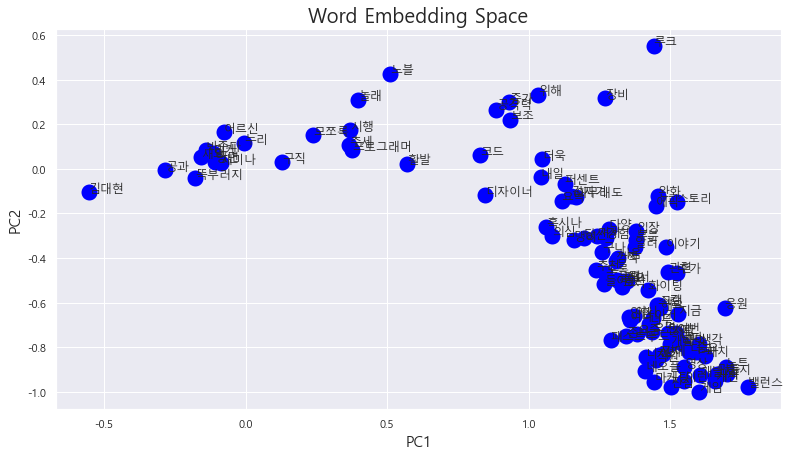

In [92]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13,7))
plt.scatter(pca_vectors[:,0], pca_vectors[:,1], linewidths=10, color='blue')
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)
plt.title("Word Embedding Space",size=20)
for i, word in enumerate(vocab_dict):
    plt.annotate(word,xy=(pca_vectors[i,0],pca_vectors[i,1]))

In [ ]:
### 3.4 던파TV 댓글 워드 임베딩 시각화

only_comments = total_comments["comment"].apply(lambda x : re.sub("[a-zA-Z0-9]","", x))
only_comments = only_comments.apply(lambda x: process(x, mecab, stopwords, split=True, min_len=2))
only_comments = only_comments.reset_index(drop=True)
only_comments = [i for i in only_comments if len(i) != 0]
only_comments[:3]

model = Word2Vec(sentences=only_comments, vector_size=100, window=5, min_count=1, workers=4, sg=1)
model.save("../word2vec.model")
word2vec_model = Word2Vec.load("../word2vec.model")
print(f" (단어의 개수 , 워드 임베딩 차원 수) : {word2vec_model.wv.vectors.shape}")
word2vec_model.wv.vectors

keyword_list = ["루크", "로젠", "프레이", "시로코", "오즈마"]
word2vec_model.wv.most_similar("밸런스", topn=100)

# 단어:단어임베딩 쌍의 dict 형성
vocab_dict = defaultdict()
for comment in only_comments:
    for word in comment:
        if word not in vocab_dict:
            vocab_dict[word] = 0
vocab_dict = dict(vocab_dict)            

for word in vocab_dict:
    vocab_dict[word] = word2vec_model.wv[word]

# 각 단어의 임베딩만 뽑아서 2D-array 형태로 만들어 줍니다.
tmp_vector= []
for vector in vocab_dict.values():
    tmp_vector.append(vector)
tmp_vector = np.array(tmp_vector)
tmp_vector.shape

# PCA로 기존 차원 수를 2개의 차원으로 축소시켜 줍니다.
pca = PCA(n_components=2)
pca_vectors = pca.fit_transform(tmp_vector)
pca_vectors.shape

pca_vectors = pca_vectors[:100]

import matplotlib.pyplot as plt
plt.figure(figsize=(13,7))
plt.scatter(pca_vectors[:,0], pca_vectors[:,1], linewidths=10, color='blue')
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)
plt.title("Word Embedding Space",size=20)
for i, word in enumerate(vocab_dict):
    plt.annotate(word,xy=(pca_vectors[i,0],pca_vectors[i,1]))